# Category-Driven Clustering of Safranbolu House Typologies using  Mixture of Experts Autoencoders

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

print('PyTorch version:', torch.__version__)

from torch.distributions.categorical import Categorical

#from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
import json
import random
import math

from sklearn.decomposition import PCA

from PIL import Image

import pandas as pd

import ipywidgets as widgets
from IPython.display import display
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from pprint import pprint

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

os.makedirs('./saved_results', exist_ok=True)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

PyTorch version: 2.3.1+cu121


device(type='cuda')

# Expertimental Settings

To reproduce the results in the paper, run the notebook with all combinations:

(USE_CATEGORICAL, USE_CLASSIFICATION) -> **EXPERIMENT NAME**

* (False, False) -> **MoE AE**
* (False, True) -> **MoE AE with Classification**
* (True, False) -> **Categorical MoE AE**
* (True, True) -> **Categorical MoE AE with Classification**

In [2]:
USE_CATEGORICAL = True
USE_CLASSIFICATION = True

# Hyperparameters

In [3]:
IMG_SIZE = 128
SEED = 1234

num_epochs = 60

batch_size = 16
learning_rate = 1e-3
latent_dim = 2

# Seed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED)

## Dataset

In [5]:
df_annotations = pd.read_excel('./data/safrangan_dataset_version_8/annotations.xlsx')
df_annotations

,Plan_Image_Filename,Floor,Sofa,Room,Hallway,Type
0,C_001_F_Plan.jpg,1,Interior,3.0,1.0,7
1,C_001_S_Plan.jpg,2,Interior,4.0,4.0,12
2,C_002_F_Plan.jpg,1,Exterior,3.0,2.0,11
3,C_002_S_Plan.jpg,2,Interior,4.0,4.0,12
4,C_003_F_Plan.jpg,1,Exterior,3.0,0.0,5
...,...,...,...,...,...,...
271,K_029_F_Plan.jpg,1,Exterior,2.0,1.0,6
272,K_029_S_Plan.jpg,2,Exterior,3.0,0.0,5
273,K_030_F_Plan.jpg,1,Exterior,3.0,0.0,5
274,K_031_F_Plan.jpg,1,Interior,4.0,4.0,11


In [6]:
typology_value_counts = df_annotations['Room'].value_counts()
typology_value_counts

Room
3.0    119
2.0     73
4.0     63
1.0     20
Name: count, dtype: int64

In [7]:
df_annotations['Type'].value_counts()

Type
12    57
11    48
7     43
6     40
4     30
5     26
3     18
1      6
10     5
2      3
Name: count, dtype: int64

### Handle Missing

In [8]:
df_annotations.isna().sum()

Plan_Image_Filename    0
Floor                  0
Sofa                   0
Room                   1
Hallway                1
Type                   0
dtype: int64

In [9]:
df_annotations.dropna(inplace=True)
df_annotations.isna().sum()

Plan_Image_Filename    0
Floor                  0
Sofa                   0
Room                   0
Hallway                0
Type                   0
dtype: int64

### Ordinal Encoding for All Features

In [10]:
from utils import encode_features

In [11]:
ALL_ENCODINGS = {}

ENCODING_COLUMNS = [
    'Floor',
    'Sofa',
    'Room',
    'Hallway',
    'Type'
]

encode_features(df_annotations, ENCODING_COLUMNS, ALL_ENCODINGS)

df_annotations.head(10)

Column name: Floor
Floor number of unique: 3
Encoding: {1: 0, 2: 1, 3: 2}
Reverse Encoding: {0: 1, 1: 2, 2: 3}

Column name: Sofa
Sofa number of unique: 2
Encoding: {'Interior': 0, 'Exterior': 1}
Reverse Encoding: {0: 'Interior', 1: 'Exterior'}

Column name: Room
Room number of unique: 4
Encoding: {3.0: 0, 4.0: 1, 2.0: 2, 1.0: 3}
Reverse Encoding: {0: 3.0, 1: 4.0, 2: 2.0, 3: 1.0}

Column name: Hallway
Hallway number of unique: 5
Encoding: {1.0: 0, 4.0: 1, 2.0: 2, 0.0: 3, 5.0: 4}
Reverse Encoding: {0: 1.0, 1: 4.0, 2: 2.0, 3: 0.0, 4: 5.0}

Column name: Type
Type number of unique: 10
Encoding: {7: 0, 12: 1, 11: 2, 5: 3, 6: 4, 3: 5, 4: 6, 2: 7, 1: 8, 10: 9}
Reverse Encoding: {0: 7, 1: 12, 2: 11, 3: 5, 4: 6, 5: 3, 6: 4, 7: 2, 8: 1, 9: 10}



,Plan_Image_Filename,Floor,Sofa,Room,Hallway,Type,Floor_Enc,Sofa_Enc,Room_Enc,Hallway_Enc,Type_Enc
0,C_001_F_Plan.jpg,1,Interior,3.0,1.0,7,0,0,0,0,0
1,C_001_S_Plan.jpg,2,Interior,4.0,4.0,12,1,0,1,1,1
2,C_002_F_Plan.jpg,1,Exterior,3.0,2.0,11,0,1,0,2,2
3,C_002_S_Plan.jpg,2,Interior,4.0,4.0,12,1,0,1,1,1
4,C_003_F_Plan.jpg,1,Exterior,3.0,0.0,5,0,1,0,3,3
5,C_003_S_Plan.jpg,2,Exterior,3.0,0.0,5,1,1,0,3,3
6,C_004_F_Plan.jpg,1,Interior,4.0,4.0,12,0,0,1,1,1
7,C_005_F_Plan.jpg,1,Exterior,2.0,1.0,6,0,1,2,0,4
8,C_005_S_Plan.jpg,2,Exterior,3.0,2.0,11,1,1,0,2,2
9,C_006_F_Plan.jpg,1,Exterior,3.0,1.0,7,0,1,0,0,0


# Dataset
### Image Transforms

In [12]:
train_transforms = v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
])

### Typology Dataset

In [13]:
from datasets import TypologyDataset

In [14]:
train_dataset = TypologyDataset(
    './data/safrangan_dataset_version_8/', 
    df_annotations,
    transform=train_transforms
)

print(f'Train dataset len: {len(train_dataset)}')

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

Train dataset len: 275


In [15]:
_i_b, _f_b = next(iter(train_loader))
_i_b.shape, _f_b.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16, 5]))

In [16]:
_i_b.min(), _i_b.max()

(tensor(0.), tensor(1.))

In [17]:
__image = _i_b[0]

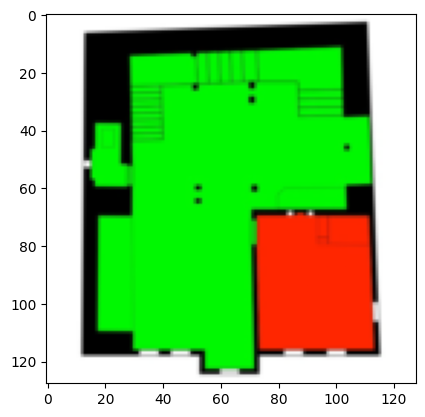

In [18]:
plt.imshow(__image.permute(1,2,0).numpy())

# Auto Encoder
### Layers

In [19]:
from layers import DownBlock, UpBlock, CategoricalLinear, AdjustSizeDown, AdjustSizeUp

In [20]:
class AE(nn.Module):
    def __init__(self, num_categories, use_categorical):
        super().__init__()
        
        self.num_categories = num_categories
        
        self.pre_encoder = nn.Sequential(
            DownBlock(3,  64),   # 64
            DownBlock(64, 128),  # 32
            DownBlock(128, 128), # 16
            DownBlock(128, 256), # 8
            DownBlock(256, 256), # 4
            DownBlock(256, 256), # 2
            DownBlock(256, 256), # 1
            AdjustSizeDown(256),  # (batch, 128)
        )

        ######### VAE #########
        self.mu = nn.Linear(256, latent_dim)
        self.log_var = nn.Linear(256, latent_dim)
        #######################
        
        self.post_encoder = nn.Sequential(
            nn.Linear(2, 256), # PRE-LATENT!!!
            nn.SiLU(),
            nn.Linear(256, num_categories+latent_dim),
        )

        # if disabled, this layer acts similar to common nn.Linear layer
        self.categorical_linear = CategoricalLinear(latent_dim, latent_dim, num_categories, enabled=use_categorical)


        self.decoder_without_sigmoid = nn.Sequential(
            nn.Linear(latent_dim, 256*1*1),
            nn.ReLU(),
            AdjustSizeUp(256), # 1
            UpBlock(256, 256), # 2
            UpBlock(256, 256), # 4
            UpBlock(256, 256), # 8 
            UpBlock(256, 128), # 16
            UpBlock(128, 128), # 32
            UpBlock(128, 64),  # 64
            UpBlock(64, 64),   # 128
            nn.Conv2d(64, 3, kernel_size=1, stride=1, padding=0),
            #nn.Sigmoid(),
        )

        self.classifier = nn.Sequential(
            nn.AvgPool2d(16), # 128 // 16 = 8
            nn.Flatten(),
            nn.Linear(3*8*8, num_categories)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def latent_representation(self, x):
        
        # temp encoding before the variational stuff happens
        temp_enc = self.pre_encoder(x)
        mu, logvar = self.mu(temp_enc), self.log_var(temp_enc) 
        pre_latent = self.reparameterize(mu, logvar)

        x_enc = self.post_encoder(pre_latent)
        
        category_logits = x_enc[:, :self.num_categories]
        latent = x_enc[:, self.num_categories:]
        
        category_probs = category_logits.softmax(dim=1)
        categorical_dist = Categorical(probs=category_probs)
        category_samples = categorical_dist.sample()

        # if disabled, sampling above wil be ignored will not effect the result
        latent = self.categorical_linear(latent, category_samples)
        
        return latent, category_logits, pre_latent, mu, logvar
        
    def forward(self, x):
        x_latent, x_category_logits, x_pre_latent, x_mu, x_logvar = self.latent_representation(x)
        x_dec = self.decoder_without_sigmoid(x_latent)
        x_class = self.classifier(x_dec)
        return x_dec, x_category_logits, x_class, x_pre_latent, x_mu, x_logvar

### Mixture of Experts (MoE)

In [21]:
class MoE(nn.Module):
    def __init__(self, use_categorical):
        super().__init__()

        self.experts = nn.ModuleList([
            AE(len(ALL_ENCODINGS['Floor_Enc']), use_categorical),
            AE(len(ALL_ENCODINGS['Sofa_Enc']), use_categorical),
            AE(len(ALL_ENCODINGS['Room_Enc']), use_categorical),
            AE(len(ALL_ENCODINGS['Hallway_Enc']), use_categorical),
            AE(len(ALL_ENCODINGS['Type_Enc']), use_categorical),
        ])

        self.expert_names = [
            'Floor',
            'Sofa',
            'Room',
            'Hallway',
            'Type',
        ]
        
        self.num_experts = len(self.experts)


    def latent_representation(self, x, expert_model_id=0):
        expert = self.experts[expert_model_id]
        latent, category_logits, pre_latent, _, _ = expert.latent_representation(x) # mu, logvar are ignored!!!
        return latent, category_logits, pre_latent

    def decoder(self, pre_latent, expert_model_id=0, category_id=None):
        expert = self.experts[expert_model_id]

        x_enc = expert.post_encoder(pre_latent)
        
        category_logits = x_enc[:, :expert.num_categories]
        latent = x_enc[:, expert.num_categories:]

        if category_id is not None:
            # MANUALLY SELECT CATEGORY
            latent = expert.categorical_linear(latent, category_id)
        else:
            # AUTO SELECT CATEGORY
            category_probs = category_logits.softmax(dim=1)
            categorical_dist = Categorical(probs=category_probs)
            category_samples = categorical_dist.sample()
            # if disabled, sampling above wil be ignored will not effect the result
            latent = expert.categorical_linear(latent, category_samples)
        
        x_pre_dec = expert.decoder_without_sigmoid(latent)

        x_dec = x_pre_dec
        
        return x_dec


    def decoder_with_predictions(self, pre_latent, expert_model_id=0, category_id=None):

        expert = self.experts[expert_model_id]

        x_enc = expert.post_encoder(pre_latent)
        
        category_logits = x_enc[:, :expert.num_categories]
        latent = x_enc[:, expert.num_categories:]

        if category_id is not None:
            # MANUALLY SELECT CATEGORY
            latent = expert.categorical_linear(latent, category_id)
        else:
            # AUTO SELECT CATEGORY
            category_probs = category_logits.softmax(dim=1)
            categorical_dist = Categorical(probs=category_probs)
            category_samples = categorical_dist.sample()
            # if disabled, sampling above wil be ignored will not effect the result
            latent = expert.categorical_linear(latent, category_samples)
        
        x_pre_dec = expert.decoder_without_sigmoid(latent)

        x_dec = x_pre_dec
        
        x_class = expert.classifier(x_pre_dec)

        return x_dec, category_probs

    
    def decoder_all_with_predictions(self, pre_latent):
        
        floor_out, floor_probs = self.decoder_with_predictions(pre_latent, expert_model_id=0)
        sofa_out, sofa_probs =  self.decoder_with_predictions(pre_latent, expert_model_id=1)
        room_out, room_probs =  self.decoder_with_predictions(pre_latent, expert_model_id=2)
        hall_out, hall_probs =  self.decoder_with_predictions(pre_latent, expert_model_id=3)
        type_out, type_probs =  self.decoder_with_predictions(pre_latent, expert_model_id=4)
        
        mixed_output = floor_out + sofa_out + room_out + hall_out + type_out

        mixed_output = mixed_output.sigmoid()

        probs_dict = {
            'Floor_Enc_Probs': floor_probs,
            'Sofa_Enc_Probs': sofa_probs,
            'Room_Enc_Probs': room_probs,
            'Hallway_Enc_Probs': hall_probs,
            'Type_Enc_Probs': type_probs
        }
        
        return mixed_output, probs_dict


    def decoder_all(self, pre_latent):

        floor_out = self.decoder(pre_latent, expert_model_id=0)
        sofa_out =  self.decoder(pre_latent, expert_model_id=1)
        room_out =  self.decoder(pre_latent, expert_model_id=2)
        hall_out =  self.decoder(pre_latent, expert_model_id=3)
        type_out =  self.decoder(pre_latent, expert_model_id=4)
        
        mixed_output = floor_out + sofa_out + room_out + hall_out + type_out

        mixed_output = mixed_output.sigmoid()
        
        return mixed_output
        

    def decoder_select(self, pre_latent, experts):
        """
        Same as decoder() but uses all experts to make prediction
        """
        
        dec_outputs = []
        
        for _expert_id in experts:
            _out = self.decoder(pre_latent, expert_model_id=_expert_id)
            dec_outputs.append(_out)

        mixed_output = torch.stack(dec_outputs).sum(dim=0)
        
        mixed_output = mixed_output.sigmoid()

        return mixed_output
        
        
    def forward(self, x):
        floor_expert = self.experts[0]
        sofa_expert  = self.experts[1]
        room_expert  = self.experts[2]
        hall_expert  = self.experts[3]
        type_expert  = self.experts[4]

        floor_dec, floor_category_logits, floor_class, floor_pre_latent, floor_mu, floor_logvar = floor_expert(x)
        sofa_dec, sofa_category_logits, sofa_class, sofa_pre_latent, sofa_mu, sofa_logvar = sofa_expert(x)
        room_dec, room_category_logits, room_class, room_pre_latent, room_mu, room_logvar = room_expert(x)
        hall_dec, hall_category_logits, hall_class, hall_pre_latent, hall_mu, hall_logvar = hall_expert(x)
        type_dec, type_category_logits, type_class, type_pre_latent, type_mu, type_logvar = type_expert(x)

        mixed_output = floor_dec + sofa_dec + room_dec + hall_dec + type_dec

        mixed_output = mixed_output.sigmoid()
        
        category_dict = {
            'floor_category_logits': floor_category_logits,
            'sofa_category_logits': sofa_category_logits,
            'room_category_logits': room_category_logits,
            'hall_category_logits': hall_category_logits,
            'type_category_logits': type_category_logits,
        }

        class_dict = {
            'floor_class': floor_class,
            'sofa_class': sofa_class,
            'room_class': room_class,
            'hall_class': hall_class,
            'type_class': type_class,
        }

        pre_latent_dict = {
            'floor_pre_latent': floor_pre_latent,
            'sofa_pre_latent': sofa_pre_latent,
            'room_pre_latent': room_pre_latent,
            'hall_pre_latent': hall_pre_latent,
            'type_pre_latent': type_pre_latent,
        }

        mu_dict = {
            'floor_mu': floor_mu,
            'sofa_mu': sofa_mu,
            'room_mu': room_mu,
            'hall_mu': hall_mu,
            'type_mu': type_mu,
        }

        logvar_dict = {
            'floor_logvar': floor_logvar,
            'sofa_logvar': sofa_logvar,
            'room_logvar': room_logvar,
            'hall_logvar': hall_logvar,
            'type_logvar': type_logvar,
        }
        
        return mixed_output, category_dict, class_dict, pre_latent_dict, mu_dict, logvar_dict

In [22]:
m = MoE(USE_CATEGORICAL)

In [23]:
mo, catd, clsd, pld, mud, logvard = m(torch.randn(4, 3, IMG_SIZE, IMG_SIZE))
mo.shape, catd.keys(), clsd.keys(), pld.keys(), mud.keys(), logvard.keys()

(torch.Size([4, 3, 128, 128]),
 dict_keys(['floor_category_logits', 'sofa_category_logits', 'room_category_logits', 'hall_category_logits', 'type_category_logits']),
 dict_keys(['floor_class', 'sofa_class', 'room_class', 'hall_class', 'type_class']),
 dict_keys(['floor_pre_latent', 'sofa_pre_latent', 'room_pre_latent', 'hall_pre_latent', 'type_pre_latent']),
 dict_keys(['floor_mu', 'sofa_mu', 'room_mu', 'hall_mu', 'type_mu']),
 dict_keys(['floor_logvar', 'sofa_logvar', 'room_logvar', 'hall_logvar', 'type_logvar']))

### Categorical Loss

In [24]:
from losses import categorical_loss

### KL-Divergence Loss

In [25]:
def kl_loss(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

# Generation Utils

In [26]:
from utils import generate_images, generate_single_image

# Training loop

### Loss & Optimizer

In [27]:
model = MoE(USE_CATEGORICAL).to(device)

num_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {num_param:,}')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Number of trainable parameters: 52,615,421


### Start Training

Epoch [5/60], Avg Loss: 1.170480 [Recon: 0.216994, Categorical: 0.777385, Classification: 0.095419, KL: 0.080683]


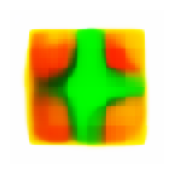

Epoch [10/60], Avg Loss: 1.018598 [Recon: 0.207474, Categorical: 0.635427, Classification: 0.082030, KL: 0.093667]


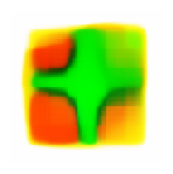

Epoch [15/60], Avg Loss: 0.926495 [Recon: 0.203648, Categorical: 0.558786, Classification: 0.081707, KL: 0.082354]


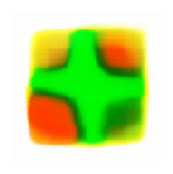

Epoch [20/60], Avg Loss: 0.830321 [Recon: 0.199140, Categorical: 0.475372, Classification: 0.072070, KL: 0.083738]


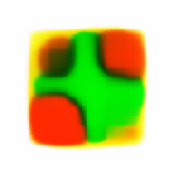

Epoch [25/60], Avg Loss: 0.780480 [Recon: 0.193101, Categorical: 0.441649, Classification: 0.064284, KL: 0.081446]


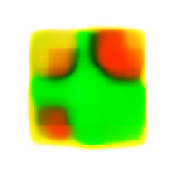

Epoch [30/60], Avg Loss: 0.837916 [Recon: 0.194968, Categorical: 0.485569, Classification: 0.069407, KL: 0.087972]


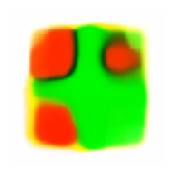

Epoch [35/60], Avg Loss: 0.706365 [Recon: 0.193734, Categorical: 0.376446, Classification: 0.054502, KL: 0.081684]


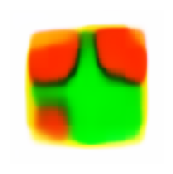

Epoch [40/60], Avg Loss: 0.711540 [Recon: 0.191791, Categorical: 0.388635, Classification: 0.052641, KL: 0.078473]


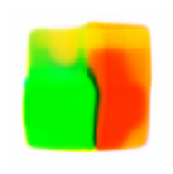

Epoch [45/60], Avg Loss: 0.591006 [Recon: 0.184807, Categorical: 0.274797, Classification: 0.044842, KL: 0.086561]


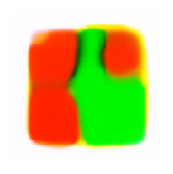

NEW LR: 0.00010000
Epoch [50/60], Avg Loss: 0.569275 [Recon: 0.187893, Categorical: 0.258410, Classification: 0.041344, KL: 0.081628]


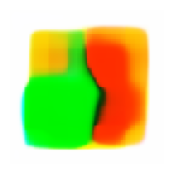

Epoch [55/60], Avg Loss: 0.427851 [Recon: 0.181904, Categorical: 0.143250, Classification: 0.023805, KL: 0.078892]


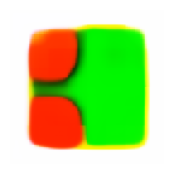

Epoch [60/60], Avg Loss: 0.398266 [Recon: 0.182246, Categorical: 0.121632, Classification: 0.018630, KL: 0.075758]


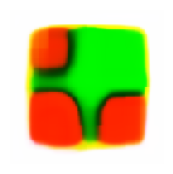

In [28]:
calc_avg = lambda x: sum(x) / len(x)

for epoch in range(1, num_epochs+1):
    avg_total_loss = []
    avg_recon_loss = []
    avg_categorical_loss = []
    avg_classification_loss = []
    avg_pre_latent_loss = []
    avg_kl_loss = []

    model.train()

    #    0       1       2        3        4 
    # Floor_Enc Sofa_Enc Room_Enc Hallway_Enc Type_Enc
    for i, (images, feature_ids) in enumerate(train_loader):
        optimizer.zero_grad()

        images    = images.to(device)
        floor_ids = feature_ids[:, 0].to(device)
        sofa_ids  =  feature_ids[:, 1].to(device)
        room_ids  = feature_ids[:, 2].to(device)
        hall_ids  = feature_ids[:, 3].to(device)
        type_ids  = feature_ids[:, 4].to(device)
        
        recon_images, category_dict, class_dict, pre_latent_dict, mu_dict, logvar_dict = model(images)
        
        #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
        ### CATEGORICAL ###
        # category_dict.keys(): ['floor_category_logits', 'sofa_category_logits', 'room_category_logits', 'hall_category_logits', 'type_category_logits']
        pred_floor_logits = category_dict['floor_category_logits']
        pred_sofa_logits  = category_dict['sofa_category_logits']
        pred_room_logits  = category_dict['room_category_logits']
        pred_hall_logits  = category_dict['hall_category_logits']
        pred_type_logits  = category_dict['type_category_logits']

        c_floor_loss = categorical_loss(pred_floor_logits, floor_ids)
        c_sofa_loss  = categorical_loss(pred_sofa_logits, sofa_ids)
        c_room_loss  = categorical_loss(pred_room_logits, room_ids)
        c_hall_loss  = categorical_loss(pred_hall_logits, hall_ids)
        c_type_loss  = categorical_loss(pred_type_logits, type_ids)

        if USE_CATEGORICAL:
            c_loss = (c_floor_loss + c_sofa_loss + c_room_loss + c_hall_loss + c_type_loss) / 5.0
        else:
            c_loss = torch.tensor(0.0, device=device)
        #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


        ##########################################################################################################
        # class_dict.keys(): dict_keys(['floor_class', 'sofa_class', 'room_class', 'hall_class', 'type_class']))
        ### CLASS ###
        pred_floor_class = class_dict['floor_class']
        pred_sofa_class  = class_dict['sofa_class']
        pred_room_class  = class_dict['room_class']
        pred_hall_class  = class_dict['hall_class']
        pred_type_class  = class_dict['type_class']

        floor_class_loss = F.cross_entropy(pred_floor_class, floor_ids.to(torch.long))
        sofa_class_loss  = F.cross_entropy(pred_sofa_class, sofa_ids.to(torch.long))
        room_class_loss  = F.cross_entropy(pred_room_class, room_ids.to(torch.long))
        hall_class_loss  = F.cross_entropy(pred_hall_class, hall_ids.to(torch.long))
        type_class_loss  = F.cross_entropy(pred_type_class, type_ids.to(torch.long))

        if USE_CLASSIFICATION:
            class_loss = 0.1 * (floor_class_loss + sofa_class_loss + room_class_loss + hall_class_loss + type_class_loss) / 5.0
        else:
            class_loss = torch.tensor(0.0, device=device)
        ##########################################################################################################

        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        # KL-DIV LOSS -> VARIATIONAL LOSS
        pred_floor_mu = mu_dict['floor_mu']
        pred_sofa_mu  = mu_dict['sofa_mu']
        pred_room_mu  = mu_dict['room_mu']
        pred_hall_mu  = mu_dict['hall_mu']
        pred_type_mu  = mu_dict['type_mu']

        pred_floor_logvar = logvar_dict['floor_logvar']
        pred_sofa_logvar  = logvar_dict['sofa_logvar']
        pred_room_logvar  = logvar_dict['room_logvar']
        pred_hall_logvar  = logvar_dict['hall_logvar']
        pred_type_logvar  = logvar_dict['type_logvar']

        floor_kl_loss = kl_loss(pred_floor_mu, pred_floor_logvar)
        sofa_kl_loss  = kl_loss(pred_sofa_mu, pred_sofa_logvar)
        room_kl_loss  = kl_loss(pred_room_mu, pred_room_logvar)
        hall_kl_loss  = kl_loss(pred_hall_mu, pred_hall_logvar)
        type_kl_loss  = kl_loss(pred_type_mu, pred_type_logvar)

        kl_div_loss = 0.001 * (floor_kl_loss + sofa_kl_loss + room_kl_loss + hall_kl_loss + type_kl_loss) / 5.0

        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&

        recon_loss = (recon_images-images).abs().mean()

        loss = recon_loss + c_loss + class_loss + kl_div_loss

        avg_total_loss.append(loss.item())
        avg_recon_loss.append(recon_loss.item())
        avg_categorical_loss.append(c_loss.item())
        avg_classification_loss.append(class_loss.item())
        avg_kl_loss.append(kl_div_loss.item())
        
        loss.backward()
        optimizer.step()


    if epoch == 50:
        for pg in optimizer.param_groups:
            pg['lr'] *= 0.1
            print(f"NEW LR: {pg['lr']:.8f}")

    """
    if epoch == 100:
        for pg in optimizer.param_groups:
            pg['lr'] *= 0.1
            print(f"NEW LR: {pg['lr']:.8f}")
    """
    
    if epoch % 5 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Avg Loss: {calc_avg(avg_total_loss):.6f} [Recon: {calc_avg(avg_recon_loss):.6f}, Categorical: {calc_avg(avg_categorical_loss):.6f}, Classification: {calc_avg(avg_classification_loss):.6f}, KL: {calc_avg(avg_kl_loss):.6f}]')

        generate_single_image(model, latent_dim)
        

# Image Clusters

In [29]:
from clustering import generate_clusters

### Plot Pre Latent

In [30]:
cached_images =  torch.stack([i for i, _ in train_dataset]).to(device)

all_images_tensor.shape:  torch.Size([275, 3, 128, 128])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


all_latent.shape: torch.Size([275, 2])
all_latent_reduced.shape: (275, 2)


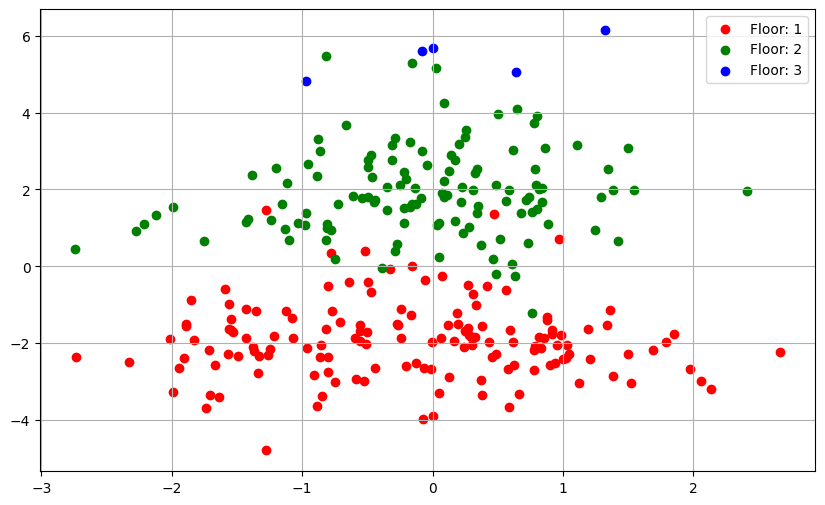

In [31]:
floor_pre_latent, all_image_tensor = generate_clusters(
    model=model, 
    dataset=train_dataset, 
    latent_dim=latent_dim, 
    all_encodings=ALL_ENCODINGS, 
    selected_encoding='Floor_Enc', 
    device=device, 
    expert_model_id=0,
    pre_latent=True,
    cached_images=cached_images
)

all_images_tensor.shape:  torch.Size([275, 3, 128, 128])
all_latent.shape: torch.Size([275, 2])
all_latent_reduced.shape: (275, 2)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


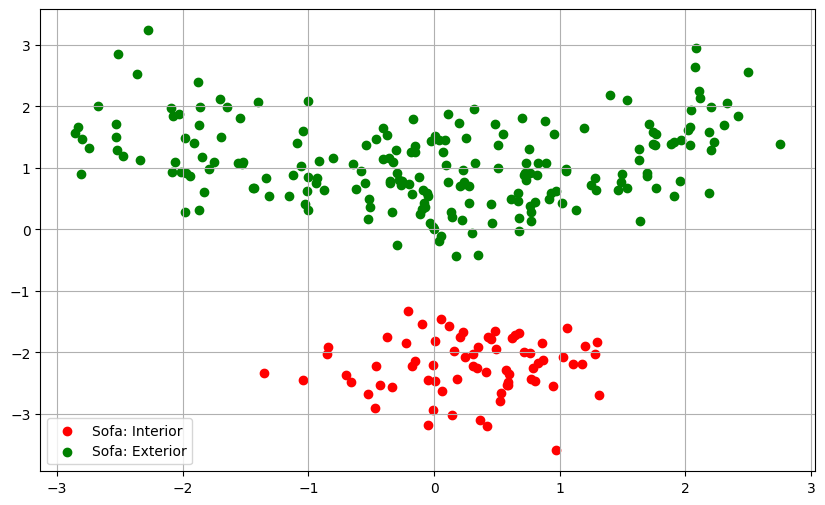

In [32]:
sofa_pre_latent, all_image_tensor = generate_clusters(
    model=model, 
    dataset=train_dataset, 
    latent_dim=latent_dim, 
    all_encodings=ALL_ENCODINGS, 
    selected_encoding='Sofa_Enc', 
    device=device, 
    expert_model_id=1,
    pre_latent=True,
    cached_images=cached_images
)

all_images_tensor.shape:  torch.Size([275, 3, 128, 128])
all_latent.shape: torch.Size([275, 2])
all_latent_reduced.shape: (275, 2)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


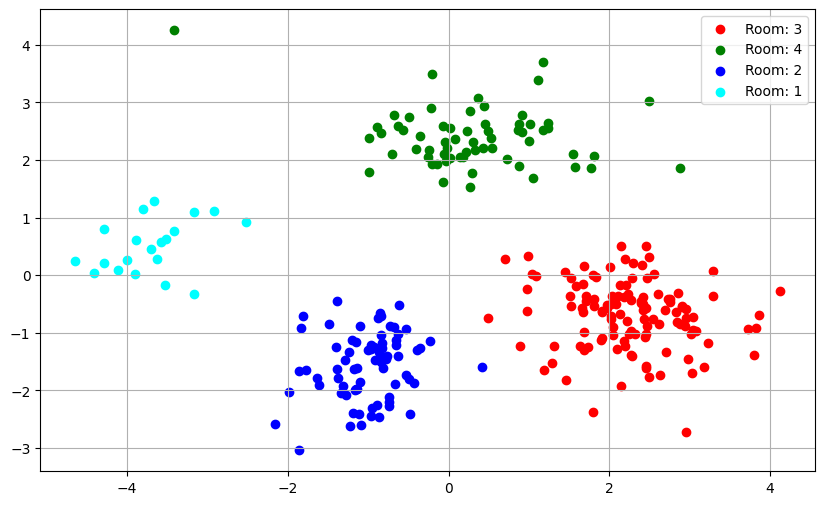

In [33]:
room_pre_latent, all_image_tensor = generate_clusters(
    model=model, 
    dataset=train_dataset, 
    latent_dim=latent_dim, 
    all_encodings=ALL_ENCODINGS, 
    selected_encoding='Room_Enc', 
    device=device, 
    expert_model_id=2,
    pre_latent=True,
    cached_images=cached_images
)

all_images_tensor.shape:  torch.Size([275, 3, 128, 128])
all_latent.shape: torch.Size([275, 2])
all_latent_reduced.shape: (275, 2)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


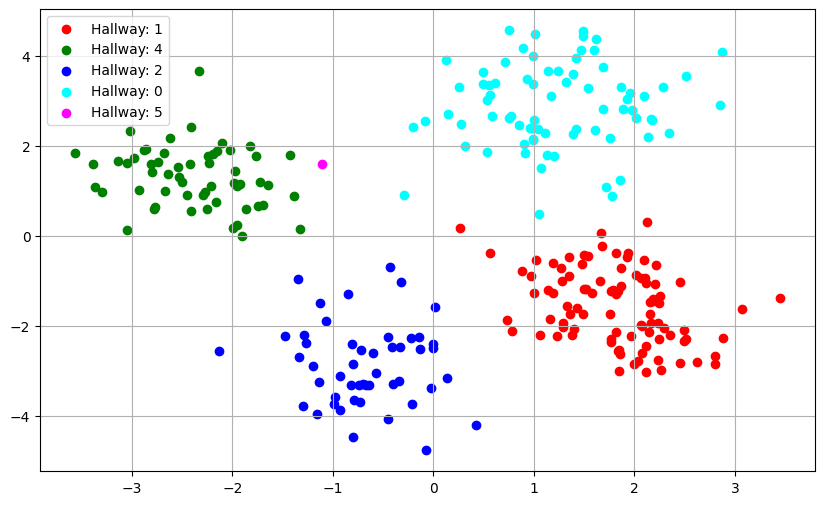

In [34]:
hallway_pre_latent, all_image_tensor = generate_clusters(
    model=model, 
    dataset=train_dataset, 
    latent_dim=latent_dim, 
    all_encodings=ALL_ENCODINGS, 
    selected_encoding='Hallway_Enc', 
    device=device, 
    expert_model_id=3,
    pre_latent=True,
    cached_images=cached_images
)

all_images_tensor.shape:  torch.Size([275, 3, 128, 128])
all_latent.shape: torch.Size([275, 2])
all_latent_reduced.shape: (275, 2)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


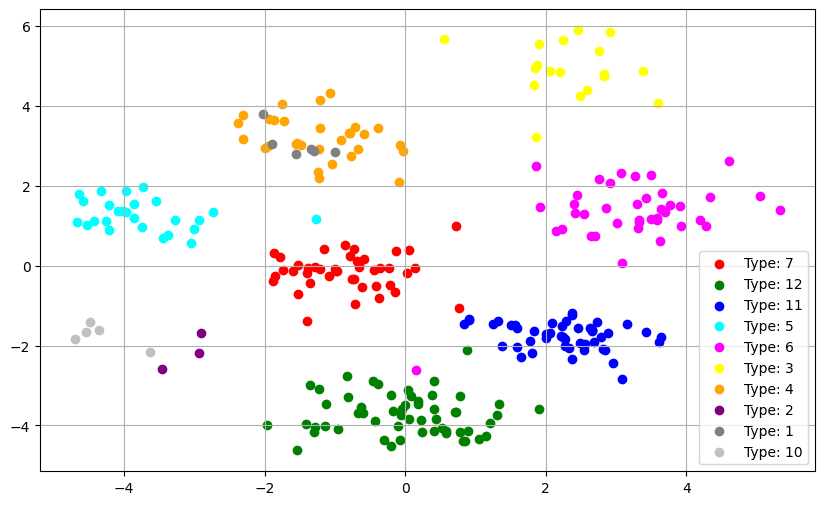

In [35]:
type_pre_latent, all_image_tensor = generate_clusters(
    model=model, 
    dataset=train_dataset, 
    latent_dim=latent_dim, 
    all_encodings=ALL_ENCODINGS, 
    selected_encoding='Type_Enc', 
    device=device, 
    expert_model_id=4,
    pre_latent=True,
    cached_images=cached_images
)

# Test Utils

In [36]:
from utils import test_category, calculcate_silhouette_scores

In [37]:
print('Floor Pre Latent Scores:')
calculcate_silhouette_scores([2, 3, 4, 5, 6, 7], floor_pre_latent, SEED)
print()

print('Sofa Pre Latent Scores:')
calculcate_silhouette_scores([2, 3, 4, 5, 6, 7], sofa_pre_latent, SEED)
print()

print('Room Pre Latent Scores:')
calculcate_silhouette_scores([2, 3, 4, 5, 6, 7], room_pre_latent, SEED)
print()

print('Hallway Pre Latent Scores:')
calculcate_silhouette_scores([2, 3, 4, 5, 6, 7], hallway_pre_latent, SEED)
print()

print('Type Pre Latent Scores:')
calculcate_silhouette_scores([2, 3, 4, 5, 6, 7], type_pre_latent, SEED)
print()

Floor Pre Latent Scores:
Num Clusters: 2  Silhouette Score K-Means: 0.560 GMM: 0.540
Num Clusters: 3  Silhouette Score K-Means: 0.440 GMM: 0.460
Num Clusters: 4  Silhouette Score K-Means: 0.393 GMM: 0.393
Num Clusters: 5  Silhouette Score K-Means: 0.388 GMM: 0.354
Num Clusters: 6  Silhouette Score K-Means: 0.388 GMM: 0.378
Num Clusters: 7  Silhouette Score K-Means: 0.381 GMM: 0.328
---> Best K-Means score: 0.560, Number of clusters: 2
---> Best GMM score: 0.540, Number of clusters: 2

Sofa Pre Latent Scores:
Num Clusters: 2  Silhouette Score K-Means: 0.541 GMM: 0.541
Num Clusters: 3  Silhouette Score K-Means: 0.525 GMM: 0.536
Num Clusters: 4  Silhouette Score K-Means: 0.517 GMM: 0.515
Num Clusters: 5  Silhouette Score K-Means: 0.462 GMM: 0.452
Num Clusters: 6  Silhouette Score K-Means: 0.441 GMM: 0.418
Num Clusters: 7  Silhouette Score K-Means: 0.466 GMM: 0.393
---> Best K-Means score: 0.541, Number of clusters: 2
---> Best GMM score: 0.541, Number of clusters: 2

Room Pre Latent Score

# Save the model

In [38]:
os.makedirs('./saved_models', exist_ok=True)

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}

torch.save(model.state_dict(), './saved_models/CategoricalMoESafranbolu.pth')

## Interactive (Clusters)

# Interactive Generation

In [39]:
@torch.no_grad()
def sample_image(model, prelatent):
    model.eval()

    _device = next(model.parameters()).device

    generated_images, prob_dict = model.decoder_all_with_predictions(prelatent.to(_device))
    generated_images = generated_images.cpu()[0]

    _label_str = ''
    
    for k, v in prob_dict.items():
        _pred_enc = k.split('_')[0]
        _pred_index = v.cpu()[0].argmax().item()

        # make an exception for Sofa (keep Interior/Exterior as string)
        if _pred_enc == 'Sofa':
            _label_str += f"{_pred_enc}: {ALL_ENCODINGS[f'{_pred_enc}_Enc_Rev'][_pred_index]} "
        else:
            _label_str += f"{_pred_enc}: {int(ALL_ENCODINGS[f'{_pred_enc}_Enc_Rev'][_pred_index])} "
        
    print(_label_str)
    
    plt.figure(figsize=(8, 2))
    plt.imshow(np.transpose(generated_images.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [40]:
def generate(x1, x2):
    
    sample_image(
        model,
        torch.tensor([[x1, x2]]),
    )
    
_ = widgets.interact(generate, x1=(-3.0, 3.0, 0.01), x2=(-3.0, 3.0, 0.01))

interactive(children=(FloatSlider(value=0.0, description='x1', max=3.0, min=-3.0, step=0.01), FloatSlider(valu…

In [41]:
def generate(x1, x2):
    
    sample_image(
        model,
        torch.tensor([[x1, x2]]),
    )
    
_ = widgets.interact(generate, x1=(-1.0, 1.0, 0.01), x2=(-1.0, 1.0, 0.01))

interactive(children=(FloatSlider(value=0.0, description='x1', max=1.0, min=-1.0, step=0.01), FloatSlider(valu…

# Subplots with Probs

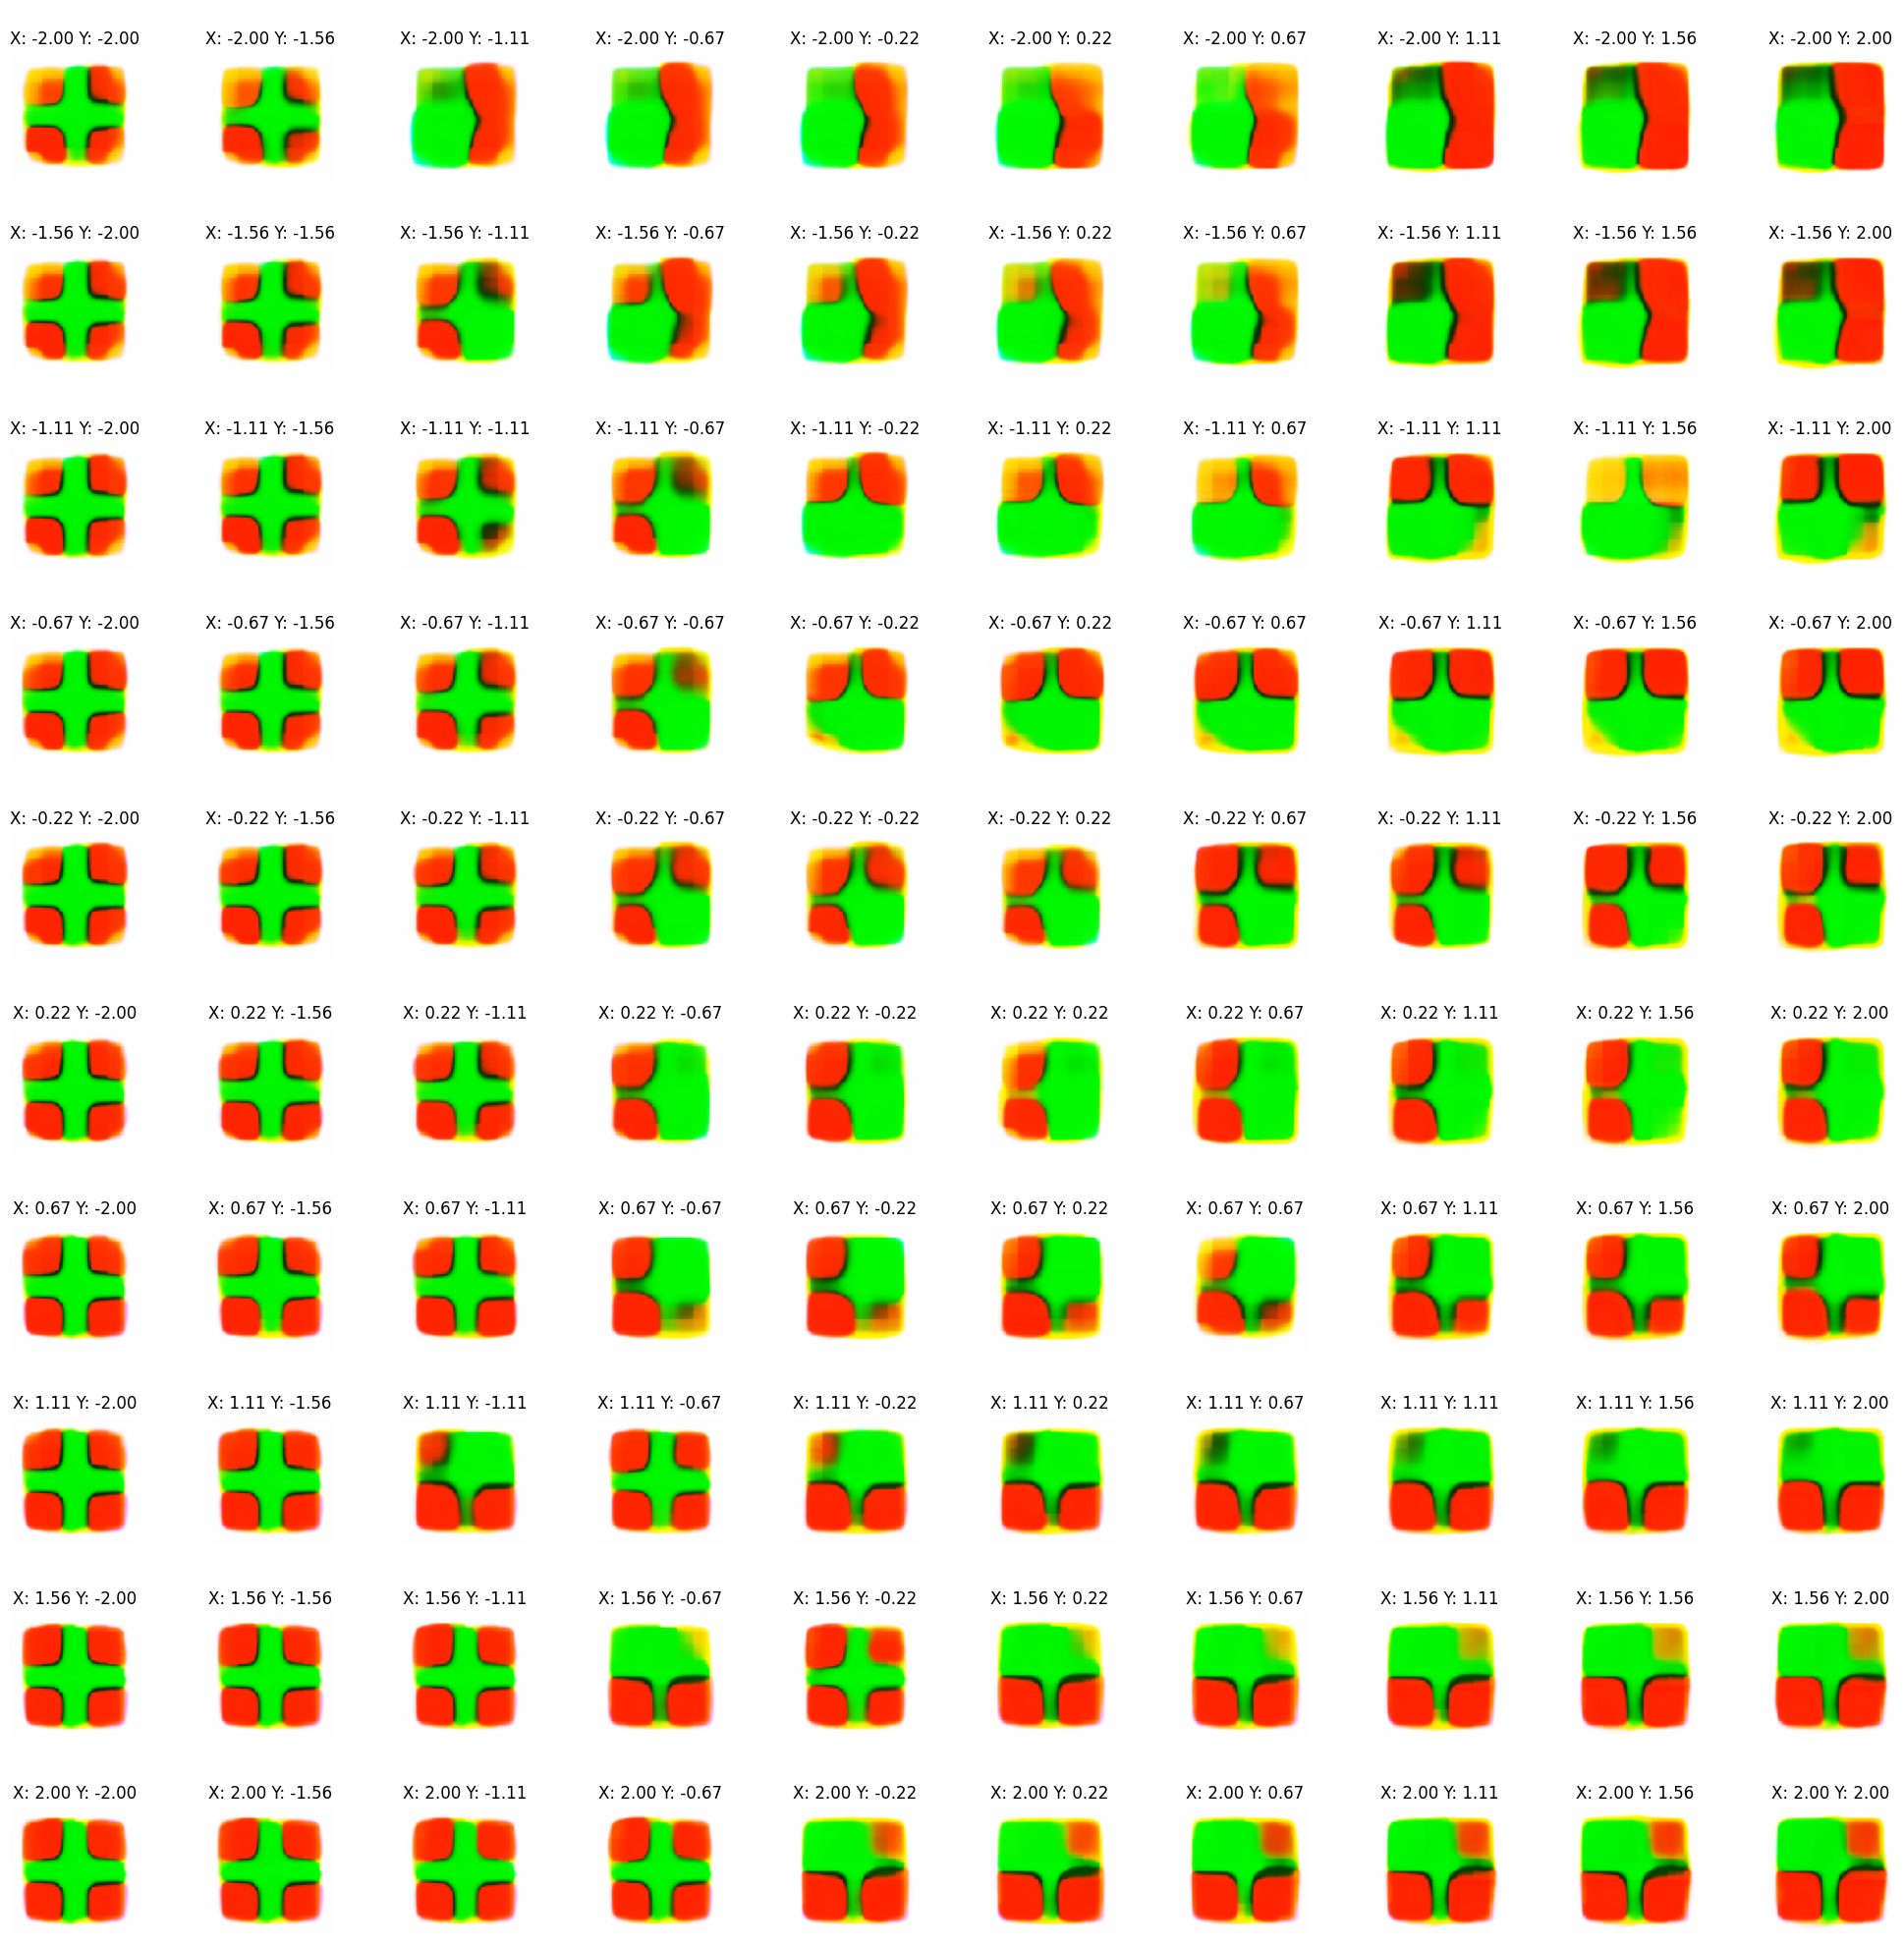

In [42]:
model.eval()

NUM_X_VALUES = 10
NUM_Y_VALUES = 10

"""
MAX_X_VALUE = type_pre_latent[:, 0].max()
MIN_X_VALUE = type_pre_latent[:, 0].min()
MAX_Y_VALUE = type_pre_latent[:, 1].max()
MIN_Y_VALUE = type_pre_latent[:, 1].min()
"""


MAX_X_VALUE = 2.0
MIN_X_VALUE = -2.0
MAX_Y_VALUE = 2.0
MIN_Y_VALUE = -2.0


fig, axes = plt.subplots(NUM_X_VALUES, NUM_Y_VALUES, figsize=(20, 20))
plt.tight_layout()

_device = next(model.parameters()).device


x_values = np.linspace(MIN_X_VALUE, MAX_X_VALUE, NUM_X_VALUES).tolist()
y_values = np.linspace(MIN_Y_VALUE, MAX_Y_VALUE, NUM_Y_VALUES).tolist()

for x_idx, x_val in enumerate(x_values):
    for y_idx, y_val in enumerate(y_values):
        #print(x_val, y_val)
        __latent = torch.tensor([[x_val, y_val]]).to(_device)

        with torch.no_grad():
            
            generated_image, prob_dict = model.decoder_all_with_predictions(__latent)
            generated_image = generated_image.cpu()[0]
            
            _label_str = f'\nX: {x_val:.2f} Y: {y_val:.2f}'

        axes[x_idx, y_idx].imshow(np.transpose(generated_image.numpy(), (1, 2, 0)))
        axes[x_idx, y_idx].set_title(_label_str)
        axes[x_idx, y_idx].axis('off')

_fig_save_path = './saved_results/typology_overview'
#plt.savefig(_fig_save_path+'.eps', format='eps', bbox_inches='tight')
plt.savefig(_fig_save_path+'.png', format='png', bbox_inches='tight')
plt.savefig(_fig_save_path+'.pdf', format='pdf', bbox_inches='tight')
plt.show()